In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix

import string
from typing import Dict
import re

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import pickle

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shaurya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/shaurya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [28]:
X_train = pd.read_pickle('data/X_train_4class.pkl')
X_test = pd.read_pickle('data/X_test_4class.pkl')
y_train = pd.read_pickle('data/y_train_4class.pkl')
y_test = pd.read_pickle('data/y_test_4class.pkl')

In [29]:
def preprocessing(raw_string: str, join_char: str = " ", lower: bool = True):
    raw_string = raw_string.replace("\t", " ")
    if lower:
        raw_string = raw_string.lower()
    for punct in string.punctuation:
        raw_string = raw_string.replace(punct, " {} ".format(punct))
    raw_string = [i for i in raw_string.split() if i]
    raw_string = join_char.join(raw_string)
    return raw_string

In [30]:
X_train[445310]

'1. In a system receiving a composite signal comprising a desired signal having desired data and an interference signal having interfering data having a plurality of frames, a method of identifying the interference signal, comprising the steps of: (a) demodulating the composite signal to produce the desired data; (b) remodulating the desired data to generate a reconstructed desired signal; (c) subtracting the reconstructed desired signal from an at least partially demodulated composite signal to generate the interference signal; (d) at least partially demodulating the interference signal using a first scrambling code of a plurality of scrambling codes to produce a first demodulated interference signal; (e) computing a histogram of a frame synchronization statistic of the first demodulated interference signal; (f) repeating steps (d) through (e) to produce additional demodulated interference signals to form a plurality of demodulated interference signals that includes the first demodula

In [31]:
preprocessing(X_train[445310])

'1 . in a system receiving a composite signal comprising a desired signal having desired data and an interference signal having interfering data having a plurality of frames , a method of identifying the interference signal , comprising the steps of : ( a ) demodulating the composite signal to produce the desired data ; ( b ) remodulating the desired data to generate a reconstructed desired signal ; ( c ) subtracting the reconstructed desired signal from an at least partially demodulated composite signal to generate the interference signal ; ( d ) at least partially demodulating the interference signal using a first scrambling code of a plurality of scrambling codes to produce a first demodulated interference signal ; ( e ) computing a histogram of a frame synchronization statistic of the first demodulated interference signal ; ( f ) repeating steps ( d ) through ( e ) to produce additional demodulated interference signals to form a plurality of demodulated interference signals that in

In [32]:
def preprocess_text(text):
    
    # Create stopwords
    stop_words = stopwords.words('english')
    custom_stops = ['claim', 'claims', 'method', 'comprising', 'comprises', 'including', 'includes', 'according']
    [stop_words.append(word) for word in custom_stops]
    
    text = preprocessing(text)
    text = re.sub('[^A-Za-z]+', ' ', text)
    text = text.split()
    keywords = [stem for stem in text if stem not in stop_words and len(stem)>2]
    return keywords

In [33]:
" ".join(preprocess_text(X_train[445310]))

'system receiving composite signal desired signal desired data interference signal interfering data plurality frames identifying interference signal steps demodulating composite signal produce desired data remodulating desired data generate reconstructed desired signal subtracting reconstructed desired signal least partially demodulated composite signal generate interference signal least partially demodulating interference signal using first scrambling code plurality scrambling codes produce first demodulated interference signal computing histogram frame synchronization statistic first demodulated interference signal repeating steps produce additional demodulated interference signals form plurality demodulated interference signals first demodulated interference signal generate plurality histograms frame synchronization statistics one histogram plurality scrambling codes identifying interference signal one plurality demodulated interference signals associated histogram lowest variance p

In [34]:
# Vectorize data
vec = TfidfVectorizer(analyzer=preprocess_text,
                      ngram_range=(1,3),
                      min_df=0.05,
                      max_df=0.9)

In [35]:
# Vectorize data for train and test sets, then pickle them for later
X_train_transformed = vec.fit_transform(X_train).toarray()

In [36]:
#X_train_transformed = vec.fit_transform(X_train).toarray()
X_train = pd.DataFrame(X_train_transformed, columns = vec.get_feature_names())
#X_train.to_pickle('data/X_train_vect_4class.pkl')

X_test_transformed = vec.transform(X_test).toarray()
X_test = pd.DataFrame(X_test_transformed, columns = vec.get_feature_names())
#X_test.to_pickle('data/X_test_vect_4class.pkl')

In [37]:
len(X_train.columns)

123

In [38]:
X_train.columns

Index(['acid', 'adjacent', 'along', 'amount', 'another', 'apparatus', 'area',
       'arranged', 'assembly', 'associated',
       ...
       'transmission', 'two', 'unit', 'user', 'using', 'value', 'vehicle',
       'via', 'wherein', 'within'],
      dtype='object', length=123)

In [42]:
logreg = LogisticRegression(random_state=42, n_jobs=1, 
                            max_iter=500, solver='lbfgs')
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
train_acc = accuracy_score(y_train,logreg.predict(X_train))
test_acc = accuracy_score(y_test,y_pred)
print(train_acc,test_acc)

0.70691875 0.70538125


In [43]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train,y_train)
y_pred2 = dt.predict(X_test)
train_acc2 = accuracy_score(y_train,dt.predict(X_train))
test_acc2 = accuracy_score(y_test,y_pred2)
print(train_acc2,test_acc2)

0.99895625 0.66223125


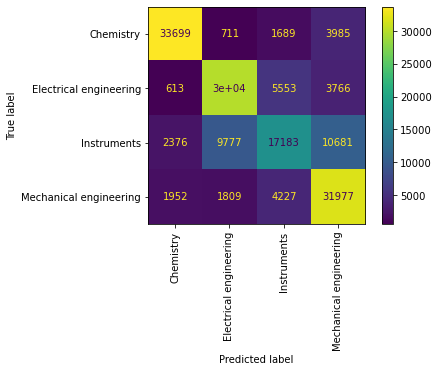

In [44]:
plot_confusion_matrix(logreg, X_test, y_test,xticks_rotation='vertical')

Text(0.5, 1.0, 'Feature Importance Top 20 - Logistic Regression')

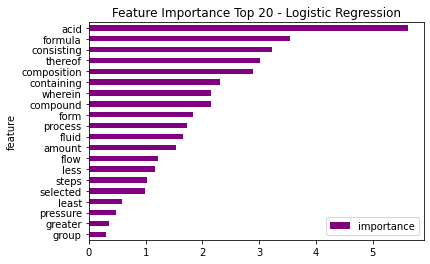

In [45]:
# get importance
feature_names = X_train.columns

# create dataframe of top features
feature_importance = pd.DataFrame(feature_names, columns = ['feature'])
feature_importance['importance'] = logreg.coef_[0]
feature_importance = feature_importance.sort_values(by = ['importance'], 
                                                    ascending=False)

# plot importance
n = 20
ax = feature_importance.iloc[:n].plot.barh(x='feature', y='importance', 
                                           color='purple').invert_yaxis()
plt.title(f'Feature Importance Top {n} - Logistic Regression')